<center>
    
 # **ACIT 4610 Mid - Tearm Portfolio Project 1**

 ## **Vehicle Routing Problem Using Quantum - Inspired Evolutionary Algorithms**

 ## **Group nr: 4**

</center>

## **1.Data Ingestion and Setup**

- import all necessary libraries and dependencies
- Load customer data
- Compute depot location
- define distance matrix

In [1]:
import time, ast, math, random
import os, time, ast, math, random, statistics as stats
from typing import NamedTuple, List, Tuple
from typing import NamedTuple, List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

Importing customers from csv file

In [2]:
#df = pd.read_csv("./customers.csv")
#df.head()


Defining  the depot as the average of all customer coordinates.

In [3]:
#depot_x = df["x"].mean()
#depot_y = df["y"].mean()
#depot = (depot_x, depot_y)

Preparing a customer coordinates list

In [4]:
# Defining distance matrix
def euclidean(a, b):
    return math.hypot(a[0]- b[0], a[1] - b[1])

def distance_matrix(depot, customers):
    pts = [tuple(depot)] + [tuple(c) for c in customers]
    n = len(pts)
    dmat = np.zeros((n,n), dtype = float)
    for i in range(n):
        for j in range(n):
            if i == j:
                dmat[i, j] = 0.0
            else:
                dmat[i, j] = euclidean(pts[i], pts[j])

    return dmat


## **2. Chromosome Representation and VRP Instances**


- VRP instances setup (small, medium , large)
- Individual route representation
- Permutation and cut points encoding

In [5]:
class VRPInstance:
    def __init__(self, depot, vehicles, customers):
        self.depot = depot
        self.customers = customers
        self.vehicles = vehicles
        # Added for CVRPLIB-capacitated runs
        self.demands: List[int] = []
        self.Q: int = None


def try_load_recommended_instances(base="./cvrp"):
    paths = {
        'A-n32-k5': os.path.join(base, "A-n32-k5.vrp"),
        'B-n78-k10': os.path.join(base, "B-n78-k10.vrp"),
        'X-n101-k25': os.path.join(base, "X-n101-k25.vrp"),
    }
    instances = {}
    for name, p in paths.items():
        if os.path.exists(p):
            instances[name] = build_instance_from_vrp(p)
        else:
            print(f"SKIP: {p} not found — place the file to enable this instance.")
    return instances



# Representation in order to choose the a chromosome format for the VRP.


class Individual(NamedTuple):
    perm: List[int]  # visit order
    cuts: List[int]  # split it to routes for each vehicle

# random intializer

def random_individual(N: int, V: int, rng:random.Random) -> Individual:
    # random permutation of all customers
    if V > N:
        raise ValueError("the number of vehicles cannot exceed number of customers.")

    perm = list(range(1, N+1))
    rng.shuffle(perm)

    #choose exactly V-1 unique cut positions
    # here maybe an error handler later

    cuts = sorted(rng.sample(range(1, N), V-1))  # random cuts same number as number of vehicles

    return Individual(perm=perm, cuts=cuts)

# decode into actualy routes
# ORIGINAL
def decode_routes(ind: Individual, V:int) -> List[List[int]]:
    perm = ind.perm
    cuts = ind.cuts

    routes = []
    prev = 0
    for c in cuts:
        routes.append(perm[prev:c])
        prev = c
    routes.append(perm[prev:])

    if len(routes) < V: routes += [[] for _ in range(V - len(routes))]  # Added
    elif len(routes) > V: routes = routes[:V]                           # Added

    return routes

# def repair_cuts(cuts: List[int], N: int, V: int, rng: random.Random) -> List[int]:
#     clamped = [min(max(1, c), N - 1) for c in cuts]
#     uniq = sorted(set(clamped))
#     need = (V - 1) - len(uniq)
#     if need > 0:
#         pool = [c for c in range(1, N) if c not in uniq]
#         add = rng.sample(pool, need)
#         uniq = sorted(uniq + add)
#     elif need < 0:
#         drop = rng.sample(range(len(uniq)), -need)
#         keep = [i for i in range(len(uniq)) if i not in drop]
#         uniq = [uniq[i] for i in keep]
#     return uniq


def route_distance(route: List[int], dmat) -> float: # distance per vehicle
    total = 0.0
    prev = 0
    for c in route:
        total += dmat[prev, c]
        prev = c
    total += dmat[prev, 0] # final route to back to depot
    return float(total)

def total_distance(ind: Individual, dmat, V: int) -> float:# distance of all the routes in a scenario
    routes = decode_routes(ind, V)
    return sum(route_distance(r, dmat) for r in routes)               #ORIGINAL
    #return sum(route_distance(r, dmat) for r in decode_routes(ind, V))

## **3. Genetic Algorithm Design**
### **3.1 GA Operators**
- selection
- crossover
- mutation


In [6]:
# NO CHANGE
def fitness(ind: Individual, dmat, V: int) -> float:
    # inorder to maximize fitness we return the negative of the total distance
    return -total_distance(ind, dmat, V)

def tournament_selection_idx(fitnesses: List[float], k: int, rng: random.Random) -> int:
    # return index of selected parent via k-tournament where higher fitness wins
    cand = [rng.randrange(len(fitnesses)) for i in range(k)]
    return max(cand, key=lambda i: fitnesses[i])

def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> Tuple[List[int], List[int]]:
    # permutation order crossover between two parents
    n = len(p1)
    a, b = sorted([rng.randrange(n), rng.randrange(n)])
    def ox(a, b, x, y):
        child = [None]*n
        child[a:b+1] = x[a:b+1]
        fill = [g for g in y if g not in child]
        pos = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[pos]; pos +=1
        return child
    return ox(a,b,p1,p2), ox(a,b,p2,p1)

def repair_cuts(cuts: List[int], N: int, V:int, rng: random.Random) -> List[int]:
    clamped = [min(max(1, c), N-1) for c in cuts] #clamp cuts to valid range
    uniq = sorted(set(clamped))
    need = (V-1)- len(uniq)
    if need > 0:
        #fill missing positions
        pool = [c for c in range(1,N) if c not in uniq]
        add = rng.sample(pool, need)
        uniq = sorted(uniq + add)
    elif need < 0:
        # trim number of cuts if to many
        drop = rng.sample(range(len(uniq)), -need)
        keep = [i for i in range(len(uniq)) if i not in drop]
        uniq = [uniq[i] for i in keep]
    return uniq

def cuts_crossover(c1: List[int], c2: List[int], N: int, V: int, rng: random.Random) -> Tuple[List[int], List[int]]:
    # one point crossover between sorted cuts and then repair
    if not c1 and not c2:
        return [], []
    a = rng.randrange(0, max(len(c1), 1))
    ch1 = sorted(c1[:a] + c2[a:])
    ch2 = sorted(c2[:a] + c1[a:])
    ch1 = repair_cuts(ch1, N, V, rng)
    ch2 = repair_cuts(ch2, N, V, rng)
    return ch1, ch2

def swap_mutation_perm(p: List[int], p_mut:float, rng: random.Random) -> List[int]:
    #swap mutation for permutation
    q = p[:]
    if rng.random() < p_mut and len(q) >= 2:
        i , j = rng.sample(range(len(q)), 2)
        q[i], q[j] = q[j], q[i]
    return q

def jitter_mutation_cuts(cuts: List[int], N:int, V:int, p_mut: float, rng: random.Random) -> List[int]:
    # jitter mutation for cuts positions
    q = cuts[:]
    if rng.random() < p_mut and q:
        i = rng.randrange(len(q))
        shift = rng.choice([1,-1])
        q[i] = min(max(1, q[i] + shift), N-1)
    return repair_cuts(q, N, V, rng)


def crossover_and_mutate(p1: Individual, p2: Individual, V: int, pc: float,
                         pm_perm: float, pm_cuts: float, rng: random.Random) -> Tuple[Individual, Individual]:
    N = len(p1.perm)
    if rng.random() < pc:
        ch1_perm, ch2_perm = order_crossover(p1.perm, p2.perm, rng)
        ch1_cuts, ch2_cuts = cuts_crossover(p1.cuts, p2.cuts, N, V, rng)
    else:
        ch1_perm, ch2_perm = p1.perm[:], p2.perm[:]
        ch1_cuts, ch2_cuts = p1.cuts[:], p2.cuts[:]

    # separate mutation rates
    ch1_perm = swap_mutation_perm(ch1_perm, pm_perm, rng)
    ch2_perm = swap_mutation_perm(ch2_perm, pm_perm, rng)
    ch1_cuts = jitter_mutation_cuts(ch1_cuts, N, V, pm_cuts, rng)
    ch2_cuts = jitter_mutation_cuts(ch2_cuts, N, V, pm_cuts, rng)
    return Individual(ch1_perm, ch1_cuts), Individual(ch2_perm, ch2_cuts)


### **3.2 GA Engine**

Main GA function to:

- initialize population
- loop over generations
- apply GA operations
- return best solution and history

In [7]:
# NO CHANGES
def genetic_algorithm(dmat, N, V, pop_size, generations, k_tourn, pc, pm_perm, pm_cuts, seed, log_convergence):
    rng = random.Random(seed)

    # init population
    pop = [random_individual(N, V, rng) for _ in range(pop_size)]
    fits = [fitness(ind, dmat, V) for ind in pop]

    best_hist = []  # best in each generation in order to track if the algorithm works

    # evolve
    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            # select parents
            a = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            b = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            p1, p2 = pop[a], pop[b]

            # crossover
            if rng.random() < pc:
                ch1_perm, ch2_perm = order_crossover(p1.perm, p2.perm, rng)
                ch1_cuts, ch2_cuts = cuts_crossover(p1.cuts, p2.cuts, N, V, rng)
            else:
                ch1_perm, ch2_perm = p1.perm[:], p2.perm[:]
                ch1_cuts, ch2_cuts = p1.cuts[:], p2.cuts[:]

            # mutation
            ch1_perm = swap_mutation_perm(ch1_perm, pm_perm, rng)
            ch2_perm = swap_mutation_perm(ch2_perm, pm_perm, rng)
            ch1_cuts = jitter_mutation_cuts(ch1_cuts, N, V, pm_cuts, rng)
            ch2_cuts = jitter_mutation_cuts(ch2_cuts, N, V, pm_cuts, rng)

            # children
            c1 = Individual(perm=ch1_perm, cuts=ch1_cuts)
            c2 = Individual(perm=ch2_perm, cuts=ch2_cuts)
            new_pop.extend([c1, c2])

        # replacement
        pop = new_pop[:pop_size]
        fits = [fitness(ind, dmat, V) for ind in pop]

        if log_convergence:
            best_idx = max(range(pop_size), key=lambda i: fits[i])
            best_hist.append(-fits[best_idx])  # store positive distance

    # best at the end
    best_idx = max(range(pop_size), key=lambda i: fits[i])
    best = pop[best_idx]
    best_dist = -fits[best_idx]

    return best, best_dist, best_hist

## Data Capacity Constarint (Assignment 2)

In [8]:
DEMANDS: List[int] = []
VEHICLE_CAPACITY: int = None

def load_cvrplib(path_vrp: str):
    """
    Minimal CVRPLIB parser for .vrp files (e.g., A-n32-k5, B-n78-k10, X-n101-k25).
    Returns (depot_xy, customers_xy, demands, Q).
    """
    coords, demands = {}, {}
    depot_id, Q, mode = None, None, None

    with open(path_vrp, "r") as f:
        for raw in f:
            s = raw.strip()
            if not s:
                continue

            # Headers / section switches
            if s.startswith("CAPACITY"):
                # e.g. "CAPACITY : 100"
                parts = s.replace(":", " ").split()
                Q = int(parts[-1])
                continue
            if s.startswith("NODE_COORD_SECTION"):
                mode = "coord"; continue
            if s.startswith("DEMAND_SECTION"):
                mode = "demand"; continue
            if s.startswith("DEPOT_SECTION"):
                mode = "depot"; continue
            if s.startswith("EOF"):
                break

            # Section content
            if mode == "coord":
                # id x y
                parts = s.split()
                if len(parts) >= 3:
                    pid = int(parts[0]); x = float(parts[1]); y = float(parts[2])
                    coords[pid] = (x, y)
            elif mode == "demand":
                # id demand
                parts = s.split()
                if len(parts) >= 2:
                    pid = int(parts[0]); d = int(parts[1])
                    demands[pid] = d
            elif mode == "depot":
                # one or more depot ids, ended by -1
                if s == "-1":
                    mode = None  # end of depot section
                    continue
                # take the first non -1 depot id
                if depot_id is None:
                    # sometimes a line can contain "1" or "1  " etc.
                    depot_id = int(s.split()[0])

    # Basic validation + common fallbacks
    if depot_id is None:
        # some files implicitly use node 1 as depot
        if 1 in coords:
            depot_id = 1
        else:
            raise ValueError("Could not determine depot id from DEPOT_SECTION.")
    if Q is None:
        raise ValueError("CAPACITY not found in file.")

    if depot_id not in coords:
        # very rare but guard anyway
        raise KeyError(f"Depot id {depot_id} not found in NODE_COORD_SECTION.")

    # Build outputs: customers are all nodes except depot
    ids = sorted(i for i in coords.keys() if i != depot_id)
    customers_xy = [coords[i] for i in ids]
    dem = [demands.get(i, 0) for i in ids]  # some benchmark headers separate DEMAND_SECTION; default 0 if missing
    depot_xy = coords[depot_id]
    return depot_xy, customers_xy, dem, Q


def set_demands_and_capacity(demands: List[int], Q: int):
    global DEMANDS, VEHICLE_CAPACITY
    DEMANDS = list(demands)
    VEHICLE_CAPACITY = int(Q)

def route_load(route: List[int], demands: List[int] = None) -> int:
    if demands is None: demands = DEMANDS
    if not route: return 0
    return int(sum(demands[i - 1] for i in route))

def capacity_violation(routes: List[List[int]], Q: int = None, demands: List[int] = None) -> int:
    if demands is None: demands = DEMANDS
    if Q is None: Q = VEHICLE_CAPACITY
    viol = 0
    for r in routes:
        load = route_load(r, demands)
        if load > Q: viol += (load - Q)
    return int(viol)

def greedy_capacity_split(route: List[int], Q: int = None, demands: List[int] = None) -> List[List[int]]:
    if demands is None: demands = DEMANDS
    if Q is None: Q = VEHICLE_CAPACITY
    parts, cur, cur_load = [], [], 0
    for v in route:
        d = demands[v - 1]
        if d > Q:
            if cur: parts.append(cur); cur, cur_load = [], 0
            parts.append([v])  # single infeasible; flagged by violation (rare in CVRPLIB)
            continue
        if cur_load + d <= Q:
            cur.append(v); cur_load += d
        else:
            parts.append(cur)
            cur, cur_load = [v], d
    if cur: parts.append(cur)
    return parts

def greedy_capacity_repair(routes: List[List[int]], V: int, Q: int = None, demands: List[int] = None, rng: random.Random = None) -> List[List[int]]:
    if rng is None: rng = random.Random()
    if demands is None: demands = DEMANDS
    if Q is None: Q = VEHICLE_CAPACITY

    # 1) split overloaded routes
    fixed = []
    for r in routes:
        if route_load(r, demands) <= Q: fixed.append(r[:])
        else:                           fixed.extend(greedy_capacity_split(r, Q, demands))
    # 2) merge while too many routes (greedy on smallest loads)
    while len(fixed) > V:
        fixed.sort(key=lambda rt: route_load(rt, demands))
        merged = False
        for i in range(len(fixed) - 1):
            a, b = fixed[i], fixed[i + 1]
            if route_load(a, demands) + route_load(b, demands) <= Q:
                fixed[i] = a + b
                fixed.pop(i + 1)
                merged = True
                break
        if not merged: break
    # 3) split while too few routes
    while len(fixed) < V and fixed:
        idx = max(range(len(fixed)), key=lambda i: route_load(fixed[i], demands))
        parts = greedy_capacity_split(fixed[idx], Q, demands)
        if len(parts) <= 1: fixed.append([])
        else:
            fixed.pop(idx)
            fixed.extend(parts[:2])  # grow route count gradually
    # pad/trim
    if len(fixed) > V: fixed = fixed[:V]
    while len(fixed) < V: fixed.append([])
    return fixed

def integrate_repair_in_offspring(ind: Individual, V: int, dmat, rng: random.Random = None) -> Individual:
    if rng is None: rng = random.Random()
    try:
        routes = decode_routes(ind, V)
    except Exception:
        return ind

    repaired = greedy_capacity_repair(routes, V, VEHICLE_CAPACITY, DEMANDS, rng)

    # --- IMPORTANT: never drop customers; ensure exactly V parts for encoding ---
    if len(repaired) > V:
        # Keep first V-1 routes, concatenate the rest into the last route
        head = repaired[:V-1]
        tail = [c for r in repaired[V-1:] for c in r]  # flatten remaining parts
        repaired = head + [ (repaired[V-1] if V-1 < len(repaired) else []) + tail ]
    elif len(repaired) < V:
        repaired = repaired + [[] for _ in range(V - len(repaired))]

    # re-encode to perm/cuts (exactly V-1 cuts)
    new_perm, new_cuts, acc = [], [], 0
    for r in repaired:
        new_perm.extend(r)
    for r in repaired[:-1]:
        acc += len(r)
        new_cuts.append(acc if acc > 0 else 1)  # keep cuts within 1..N-1
    # Guarantee cut values are valid and unique
    new_cuts = repair_cuts(new_cuts, N=len(new_perm), V=V, rng=rng)

    # final sanity: ensure perm is a permutation of 1..N
    N = len(ind.perm)
    if len(new_perm) != N or len(set(new_perm)) != N:
        # recover by projecting to a valid permutation (keeps order of first occurrences)
        seen = set()
        new_perm = [x for x in new_perm if x not in seen and not seen.add(x)]
        missing = [i for i in range(1, N+1) if i not in seen]
        new_perm.extend(missing)

    return Individual(new_perm, new_cuts)


## Objectives (MO): distance + balance

In [9]:
def objective_vector(ind: Individual, dmat, V: int, balance: str = 'max') -> Tuple[float, float]:
    # ensure feasibility prior to scoring
    routes = greedy_capacity_repair(decode_routes(ind, V), V, VEHICLE_CAPACITY, DEMANDS)
    dists = [route_distance(r, dmat) if r else 0.0 for r in routes]
    f1 = float(sum(dists))
    if balance == 'std':
        mu = (sum(dists) / len(dists)) if dists else 0.0
        f2 = float(math.sqrt(sum((x - mu) ** 2 for x in dists) / len(dists))) if dists else 0.0
    else:
        f2 = float(max(dists) if dists else 0.0)  # min–max balance
    return (f1, f2)

## MOEA utilities, NSGA-II, SPEA2

In [10]:
def dominates(a: Tuple[float, float], b: Tuple[float, float]) -> bool:
    return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])

def fast_nondominated_sort(F: List[Tuple[float, float]]) -> List[List[int]]:
    N = len(F)
    S = [set() for _ in range(N)]
    n = [0] * N
    fronts = [[]]
    for p in range(N):
        for q in range(N):
            if p == q: continue
            if dominates(F[p], F[q]):   S[p].add(q)
            elif dominates(F[q], F[p]): n[p] += 1
        if n[p] == 0:
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0: next_front.append(q)
        i += 1
        fronts.append(next_front)
    if not fronts[-1]: fronts.pop()
    return fronts

def crowding_distance(front_idx: List[int], Fvals: List[Tuple[float, float]]):
    l = len(front_idx)
    if l == 0: return {}
    dist = {i: 0.0 for i in front_idx}
    for obj in range(2):
        sidx = sorted(front_idx, key=lambda i: Fvals[i][obj])
        fmin, fmax = Fvals[sidx[0]][obj], Fvals[sidx[-1]][obj]
        dist[sidx[0]] = dist[sidx[-1]] = float('inf')
        if fmax == fmin: continue
        for k in range(1, l - 1):
            i_prev = sidx[k - 1]; i_next = sidx[k + 1]
            dist[sidx[k]] += (Fvals[i_next][obj] - Fvals[i_prev][obj]) / (fmax - fmin)
    return dist

def hypervolume_2d(points: List[Tuple[float, float]], ref: Tuple[float, float]) -> float:
    """2D HV for minimization (rectangle union via sorting)."""
    pts = [p for p in points if p[0] <= ref[0] and p[1] <= ref[1]]
    pts = sorted(pts, key=lambda x: (x[0], x[1]))
    hv, prev_f1 = 0.0, ref[0]
    for f1, f2 in reversed(pts):
        width = prev_f1 - f1
        height = ref[1] - f2
        if width < 0: width = 0
        if height < 0: height = 0
        hv += width * height
        prev_f1 = f1
    return hv


In [11]:
# NSGA-2
def nsga2(instance: VRPInstance, dmat, pop_size=100, generations=200, pc=0.9,
          pm_perm=None, pm_cuts=None, pm=None, seed=0, balance='max'):
    # backward compat: if old "pm" is given, use it for both
    if pm_perm is None and pm_cuts is None and pm is not None:
        pm_perm, pm_cuts = pm, pm
    if pm_perm is None: pm_perm = 0.2
    if pm_cuts is None: pm_cuts = 0.1

    rng = random.Random(seed)
    N = len(instance.customers); V = instance.vehicles
    set_demands_and_capacity(getattr(instance, 'demands', []), getattr(instance, 'Q', None))

    pop = [random_individual(N, V, rng) for _ in range(pop_size)]
    Fvals = [objective_vector(ind, dmat, V, balance) for ind in pop]
    history = []
    for gen in range(generations):
        fronts = fast_nondominated_sort(Fvals)
        crowd, rank = {}, {}
        for r, front in enumerate(fronts):
            c = crowding_distance(front, Fvals)
            crowd.update(c)
            for i in front: rank[i] = r

        def tour_idx():
            i, j = rng.randrange(pop_size), rng.randrange(pop_size)
            return i if (rank[i] < rank[j] or (rank[i] == rank[j] and crowd.get(i, 0) > crowd.get(j, 0))) else j

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = pop[tour_idx()], pop[tour_idx()]
            c1, c2 = crossover_and_mutate(p1, p2, V, pc, pm_perm, pm_cuts, rng)
            c1 = integrate_repair_in_offspring(c1, V, dmat, rng)
            c2 = integrate_repair_in_offspring(c2, V, dmat, rng)
            offspring.extend([c1, c2])
        offspring = offspring[:pop_size]
        off_F = [objective_vector(ind, dmat, V, balance) for ind in offspring]

        combined = pop + offspring
        combined_F = Fvals + off_F
        fronts = fast_nondominated_sort(combined_F)
        new_pop, new_F = [], []
        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                new_pop.extend([combined[i] for i in front])
                new_F.extend([combined_F[i] for i in front])
            else:
                cdist = crowding_distance(front, combined_F)
                sorted_front = sorted(front, key=lambda i: cdist[i], reverse=True)
                need = pop_size - len(new_pop)
                sel = sorted_front[:need]
                new_pop.extend([combined[i] for i in sel])
                new_F.extend([combined_F[i] for i in sel])
                break
        pop, Fvals = new_pop, new_F

        f1s = [f[0] for f in Fvals]; f2s = [f[1] for f in Fvals]
        ref = (max(f1s) * 1.1, max(f2s) * 1.1)
        pareto = [Fvals[i] for i in fast_nondominated_sort(Fvals)[0]]
        history.append({'gen': gen, 'hypervolume': hypervolume_2d(pareto, ref), 'pareto': pareto})
    return pop, Fvals, history


In [12]:
# SPEA-2
def spea2(instance: VRPInstance, dmat, pop_size=100, archive_size=None, generations=200, pc=0.9,
          pm_perm=None, pm_cuts=None, pm=None, seed=0, balance='max'):
    # backward compat
    if pm_perm is None and pm_cuts is None and pm is not None:
        pm_perm, pm_cuts = pm, pm
    if pm_perm is None: pm_perm = 0.2
    if pm_cuts is None: pm_cuts = 0.1

    rng = random.Random(seed)
    if archive_size is None: archive_size = pop_size
    N = len(instance.customers); V = instance.vehicles
    set_demands_and_capacity(getattr(instance, 'demands', []), getattr(instance, 'Q', None))

    pop = [random_individual(N, V, rng) for _ in range(pop_size)]
    Fvals = [objective_vector(ind, dmat, V, balance) for ind in pop]
    archive, archive_F = [], []
    history = []
    for gen in range(generations):
        union, union_F = pop + archive, Fvals + archive_F
        M = len(union)
        S = [0]*M
        for i in range(M):
            for j in range(M):
                if dominates(union_F[i], union_F[j]): S[i] += 1
        R = [0]*M
        for i in range(M):
            for j in range(M):
                if dominates(union_F[j], union_F[i]): R[i] += S[j]
        k = max(1, int(math.sqrt(M)))
        dists = [[0.0]*M for _ in range(M)]
        for i in range(M):
            for j in range(M):
                if i == j: dists[i][j] = float('inf'); continue
                a, b = union_F[i], union_F[j]
                dists[i][j] = math.hypot(a[0] - b[0], a[1] - b[1])
        D = []
        for i in range(M):
            sorted_d = sorted(dists[i])
            kth = sorted_d[k] if k < len(sorted_d) else sorted_d[-1]
            D.append(1.0 / (kth + 2e-9))
        fitness = [R[i] + D[i] for i in range(M)]

        pairs = list(enumerate(fitness))
        pairs.sort(key=lambda x: x[1])
        archive_idx = [idx for idx, _ in pairs[:archive_size]]
        archive = [union[i] for i in archive_idx]
        archive_F = [union_F[i] for i in archive_idx]

        while len(archive) > archive_size:
            K = len(archive)
            dd = [[0.0]*K for _ in range(K)]
            for i in range(K):
                for j in range(K):
                    if i == j: dd[i][j] = float('inf'); continue
                    a, b = archive_F[i], archive_F[j]
                    dd[i][j] = math.hypot(a[0] - b[0], a[1] - b[1])
            mins = [min(row) for row in dd]
            remove = mins.index(min(mins))
            archive.pop(remove); archive_F.pop(remove)

        if archive_F:
            f1s = [f[0] for f in archive_F]; f2s = [f[1] for f in archive_F]
            ref = (max(f1s) * 1.1, max(f2s) * 1.1)
            pareto = [archive_F[i] for i in fast_nondominated_sort(archive_F)[0]]
            hv = hypervolume_2d(pareto, ref)
        else:
            hv, pareto = 0.0, []
        history.append({'gen': gen, 'hypervolume': hv, 'pareto': pareto})

        def tour_idx():
            i, j = rng.randrange(len(archive)), rng.randrange(len(archive))
            fi = archive_F[i][0] + archive_F[i][1]
            fj = archive_F[j][0] + archive_F[j][1]
            return i if fi < fj else j

        offspring = []
        while len(offspring) < pop_size:
            p1 = archive[tour_idx()]; p2 = archive[tour_idx()]
            c1, c2 = crossover_and_mutate(p1, p2, V, pc, pm_perm, pm_cuts, rng)
            c1 = integrate_repair_in_offspring(c1, V, dmat, rng)
            c2 = integrate_repair_in_offspring(c2, V, dmat, rng)
            offspring.extend([c1, c2])
        pop = offspring[:pop_size]
        Fvals = [objective_vector(ind, dmat, V, balance) for ind in pop]
    return archive, archive_F, history

In [13]:
def build_distance_matrix(depot_xy, customers_xy):
    return distance_matrix(depot_xy, customers_xy)

def run_experiments(instances: Dict[str, VRPInstance],
                    algs: List[Tuple[str, Any]],
                    param_sets: List[Dict[str, Any]],
                    runs: int = 20,
                    balance: str = 'max',
                    seed0: int = 0) -> pd.DataFrame:
    rows = []
    for inst_name, inst in instances.items():
        dmat = build_distance_matrix(inst.depot, inst.customers)
        for (alg_name, alg_fn) in algs:
            for pidx, P in enumerate(param_sets):
                for r in range(runs):
                    seed = seed0 + 7919 * r + 127 * pidx
                    t0 = time.time()
                    out = alg_fn(inst, dmat, **P, seed=seed, balance=balance)
                    elapsed = time.time() - t0
                    if alg_name == 'NSGA-II':
                        pop, Fvals, hist = out
                        pareto = [Fvals[i] for i in fast_nondominated_sort(Fvals)[0]]
                    else:
                        archive, archive_F, hist = out
                        pareto = [archive_F[i] for i in fast_nondominated_sort(archive_F)[0]] if archive_F else []
                    if pareto:
                        ref = (max(p[0] for p in pareto) * 1.1, max(p[1] for p in pareto) * 1.1)
                        hv = hypervolume_2d(pareto, ref)
                    else:
                        hv = 0.0
                    rows.append({
                        'instance': inst_name,
                        'algorithm': alg_name,
                        'param_set': pidx + 1,
                        'run': r + 1,
                        'hypervolume': hv,
                        'runtime_sec': elapsed,
                        'pareto_count': len(pareto)
                    })
    return pd.DataFrame(rows)

In [14]:
def plot_pareto(Fvals: List[Tuple[float, float]], title='Pareto front'):
    fronts = fast_nondominated_sort(Fvals)
    if not fronts: return
    f0 = fronts[0]
    xs = [Fvals[i][0] for i in f0]; ys = [Fvals[i][1] for i in f0]
    plt.figure(figsize=(6, 4))
    plt.scatter(xs, ys, s=24)
    plt.xlabel('Total distance (min)')
    plt.ylabel('Route balance (min)')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [15]:
# CVRPLIB convenience loader (A/B/X)

def build_instance_from_vrp(path: str, vehicles: int = None) -> VRPInstance:
    depot_xy, customers_xy, dem, Q = load_cvrplib(path)
    inst = VRPInstance(depot=depot_xy, vehicles=vehicles if vehicles else 0, customers=customers_xy)
    inst.demands = dem; inst.Q = Q
    if vehicles is None:
        base = os.path.basename(path)
        if '-k' in base:
            try: inst.vehicles = int(base.split('-k')[-1].split('.')[0])
            except Exception: pass
    return inst


   instance algorithm  param_set  run  hypervolume  runtime_sec  pareto_count
0  A-n32-k5   NSGA-II          1    1  7798.496996     1.193035            50
1  A-n32-k5   NSGA-II          1    2  4199.556094     0.922563             5
2  A-n32-k5   NSGA-II          1    3  2180.852437     0.934943            14
3  A-n32-k5   NSGA-II          1    4  6673.274819     0.895437             4
4  A-n32-k5   NSGA-II          1    5  1821.720711     0.955025             1


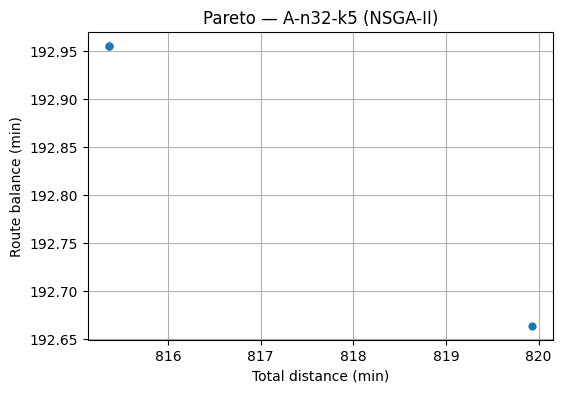


=== Summary (mean/best/worst HV & runtime) ===
  instance algorithm  param_set      hv_mean      hv_best      hv_worst   rt_mean   rt_best  rt_worst  pareto_avg
  A-n32-k5   NSGA-II          1 6.437338e+03 2.604391e+04   1730.245366  1.011791  0.892473  1.572594       22.40
  A-n32-k5   NSGA-II          2 4.671848e+03 1.707519e+04   1661.412279  5.930533  5.192676  6.636686       48.25
  A-n32-k5   NSGA-II          3 5.543223e+03 1.864800e+04   1400.099367 29.888003 28.621331 32.078756      175.25
  A-n32-k5     SPEA2          1 5.613737e+03 1.133647e+04   1750.082858  1.226529  1.092063  1.849505        8.80
  A-n32-k5     SPEA2          2 4.213364e+03 1.105448e+04   1486.711581  7.750042  7.001945  8.237223        8.30
  A-n32-k5     SPEA2          3 4.837342e+03 1.006177e+04   2034.265391 41.664474 41.058697 42.594136       17.10
 B-n78-k10   NSGA-II          1 1.046389e+04 2.292506e+04   3308.737119  1.796155  1.583184  2.851591       15.00
 B-n78-k10   NSGA-II          2 8.429036

In [16]:
if __name__ == "__main__":
    # Load CVRP-LIB
    instances = try_load_recommended_instances("./cvrp")

    # Define algorithms and parameter sets
    algs = [
        ('NSGA-II', nsga2),
        ('SPEA2',  lambda inst, dmat, **P: spea2(inst, dmat, archive_size=P.get('pop_size', 100), **P)),
    ]
    param_sets = [
        {"pop_size": 50, "generations": 100, "pc": 0.7, "pm_perm": 0.2, "pm_cuts": 0.1},
        {"pop_size": 100, "generations": 200, "pc": 0.8, "pm_perm": 0.3, "pm_cuts": 0.15},
        {"pop_size": 200, "generations": 300, "pc": 0.9, "pm_perm": 0.4, "pm_cuts": 0.2}
    ]

    # Run experiments (≥20 runs)
    if instances:
        dfres = run_experiments(instances, algs, param_sets, runs=20, balance='max', seed0=0)
        print(dfres.head())

        # Example: show NSGA-II Pareto for A-n32-k5 (one run)
        if 'A-n32-k5' in instances:
            inst = instances['A-n32-k5']
            set_demands_and_capacity(inst.demands, inst.Q)
            dmat = build_distance_matrix(inst.depot, inst.customers)
            pop, Fvals, hist = nsga2(inst, dmat, **param_sets[1], seed=0, balance='max')
            plot_pareto(Fvals, title='Pareto — A-n32-k5 (NSGA-II)')

        # Basic summary tables
        sum_tbl = (dfres
                   .groupby(['instance', 'algorithm', 'param_set'], as_index=False)
                   .agg(hv_mean=('hypervolume','mean'),
                        hv_best=('hypervolume','max'),
                        hv_worst=('hypervolume','min'),
                        rt_mean=('runtime_sec','mean'),
                        rt_best=('runtime_sec','min'),
                        rt_worst=('runtime_sec','max'),
                        pareto_avg=('pareto_count','mean')))
        print("\n=== Summary (mean/best/worst HV & runtime) ===")
        print(sum_tbl.sort_values(['instance','algorithm','param_set']).to_string(index=False))
    else:
        print("No instances loaded. Place CVRPLIB files under ./cvrp and re-run.")


-------------------------

## Not done anything past this line

## **4.Visualization**
- Visualize routes for each instance



In [17]:
# ChatGPT

def plot_routes(ind: Individual,
                customers: List[Tuple[float, float]],
                depot: Tuple[float, float],
                n_vehicles: int,
                number_points: bool = False,
                title: str = None,
                feasible: bool = True,
                ax=None):
    """
    Plot routes for an Individual. If feasible=True, the routes are repaired
    (capacity) before plotting so what you see is feasible in CVRPLIB terms.
    """
    routes = decode_routes(ind, n_vehicles)
    if feasible:
        routes = greedy_capacity_repair(routes, n_vehicles, VEHICLE_CAPACITY, DEMANDS)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # scatter: customers + depot
    xs = [xy[0] for xy in customers]
    ys = [xy[1] for xy in customers]
    ax.scatter(xs, ys, s=20, label="customers")
    ax.scatter([depot[0]], [depot[1]], marker=".", s=400,
               label="depot", edgecolors="red", color="black", zorder=10)

    # annotate customer ids if requested (1..N)
    if number_points:
        for i, (x, y) in enumerate(customers, start=1):
            ax.text(x, y, str(i), fontsize=8, ha='center', va='center')

    # draw each route
    for r in routes:
        if not r:  # empty vehicle
            continue
        xs_path = [depot[0]] + [customers[i-1][0] for i in r] + [depot[0]]
        ys_path = [depot[1]] + [customers[i-1][1] for i in r] + [depot[1]]
        ax.plot(xs_path, ys_path, linewidth=1.2)

    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="best", frameon=False)
    ax.set_title(title or f"Decoded Routes (vehicles={n_vehicles})")


def _select_solution(Fvals: List[Tuple[float, float]], how: str = 'knee') -> int:
    """
    Choose which Pareto solution to plot.
    - 'min_f1': smallest total distance
    - 'min_f2': best balance (min max-route or std)
    - 'knee'  : closest to utopia point (min f1, min f2)
    """
    if not Fvals:
        return 0
    if how == 'min_f1':
        return min(range(len(Fvals)), key=lambda i: Fvals[i][0])
    if how == 'min_f2':
        return min(range(len(Fvals)), key=lambda i: Fvals[i][1])
    # knee via distance to utopia (min f1, min f2)
    f1min = min(f[0] for f in Fvals)
    f2min = min(f[1] for f in Fvals)
    return min(range(len(Fvals)),
               key=lambda i: math.hypot(Fvals[i][0] - f1min, Fvals[i][1] - f2min))


def visualize_routes_for_all_instances(instances: Dict[str, VRPInstance],
                                       alg_name: str = 'NSGA-II',
                                       param_sets: List[Dict[str, Any]] = None,
                                       param_set_index: int = 1,
                                       selection: str = 'knee',
                                       number_points: bool = False,
                                       feasible: bool = True,
                                       seed: int = 0):
    """
    Run the chosen MOEA once per instance and plot one representative solution
    (selected from the Pareto set) for each instance in a grid.
    """
    if not instances:
        print("No instances to visualize.")
        return

    if param_sets is None or not (0 <= param_set_index < len(param_sets)):
        raise ValueError("param_sets must be provided and param_set_index must be valid.")

    # map algorithm name to function
    alg_map = {
        'NSGA-II': nsga2,
        'SPEA2':   lambda inst, dmat, **P: spea2(inst, dmat, archive_size=P.get('pop_size', 100), **P),
    }
    if alg_name not in alg_map:
        raise ValueError("alg_name must be 'NSGA-II' or 'SPEA2'.")

    alg_fn = alg_map[alg_name]
    P = dict(param_sets[param_set_index])  # copy so we can tweak if needed

    # layout
    names = list(instances.keys())
    n_instances = len(names)
    cols = 2
    rows = (n_instances + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
    axes = np.atleast_1d(axes).flatten()

    for idx, name in enumerate(names):
        inst = instances[name]
        # set global capacity helpers for safe plotting/repair
        set_demands_and_capacity(getattr(inst, 'demands', []), getattr(inst, 'Q', None))
        dmat = build_distance_matrix(inst.depot, inst.customers)

        # run MOEA
        out = alg_fn(inst, dmat, **P, seed=seed, balance='max')
        if alg_name == 'NSGA-II':
            pop, Fvals, hist = out
            idx_sel = _select_solution(Fvals, selection)
            ind_sel = pop[idx_sel]
            f1, f2 = Fvals[idx_sel]
        else:
            archive, archive_F, hist = out
            if not archive:
                # fall back: random individual if archive empty (shouldn't happen)
                ind_sel = random_individual(N=len(inst.customers), V=inst.vehicles, rng=random.Random(seed))
                f1, f2 = objective_vector(ind_sel, dmat, inst.vehicles)
            else:
                idx_sel = _select_solution(archive_F, selection)
                ind_sel = archive[idx_sel]
                f1, f2 = archive_F[idx_sel]

        ax = axes[idx]
        title = f"{name} — {alg_name}\n{selection}: dist={f1:.1f}, balance={f2:.1f}"
        plot_routes(ind_sel, customers=inst.customers, depot=inst.depot,
                    n_vehicles=inst.vehicles, number_points=number_points,
                    title=title, feasible=feasible, ax=ax)

    # hide any unused subplots
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

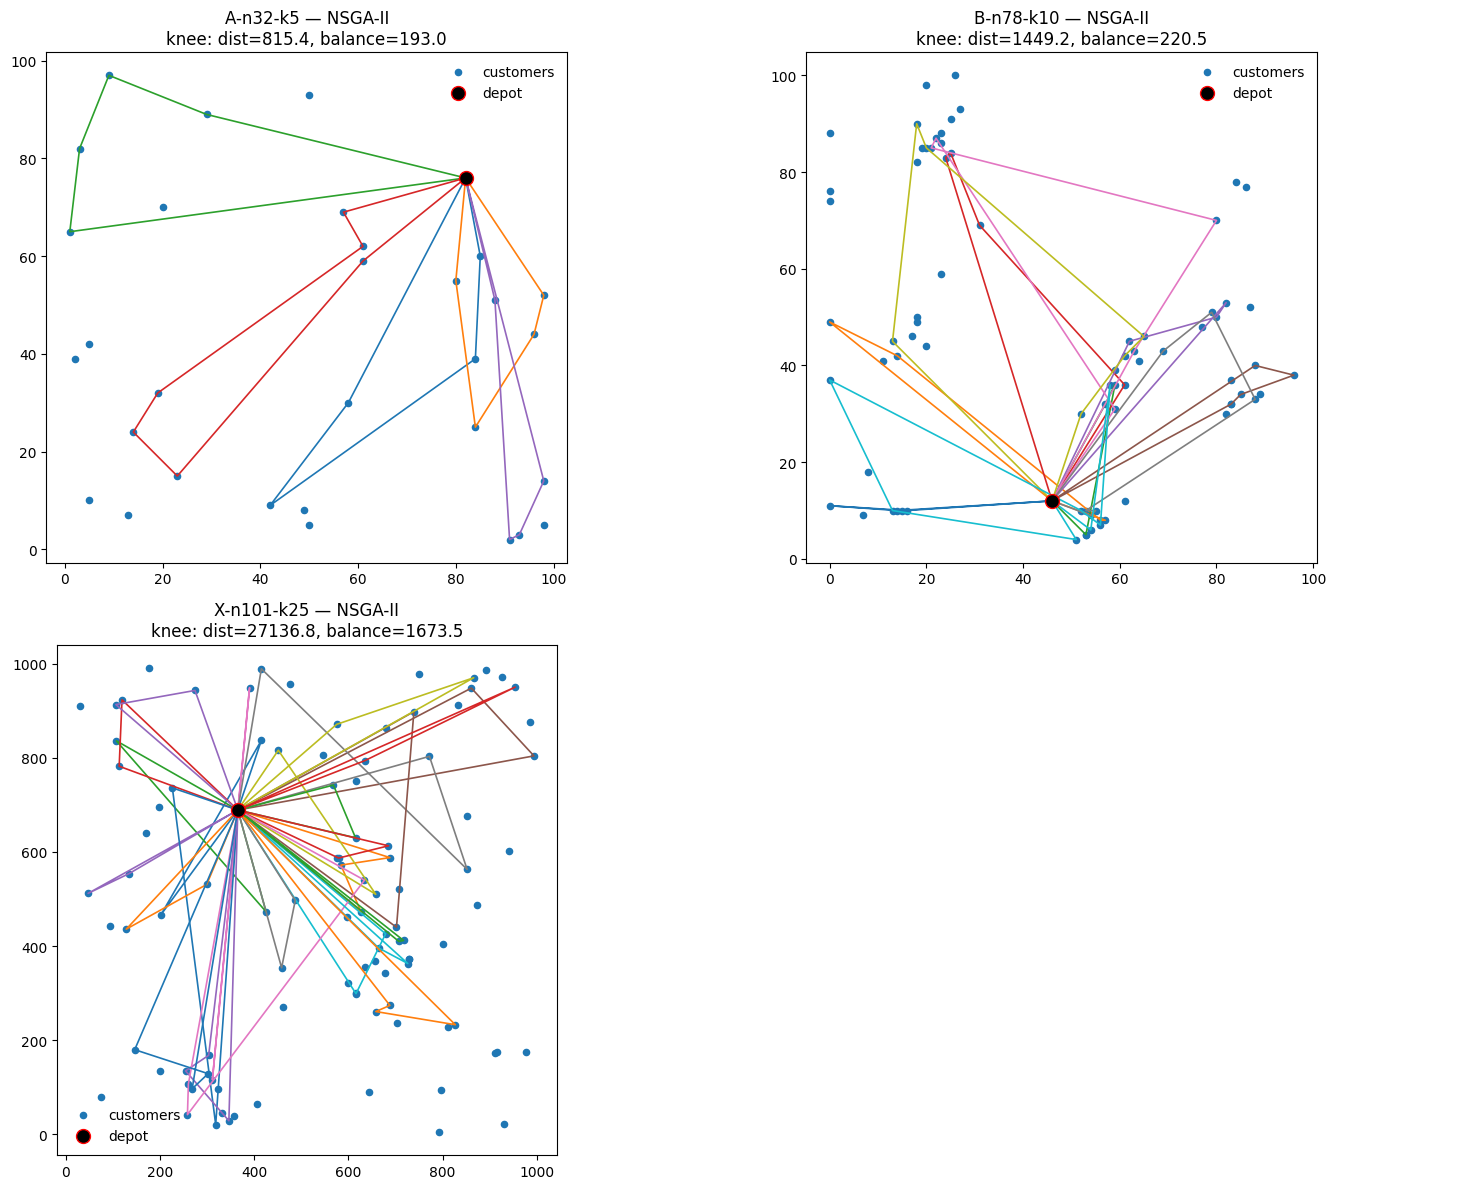

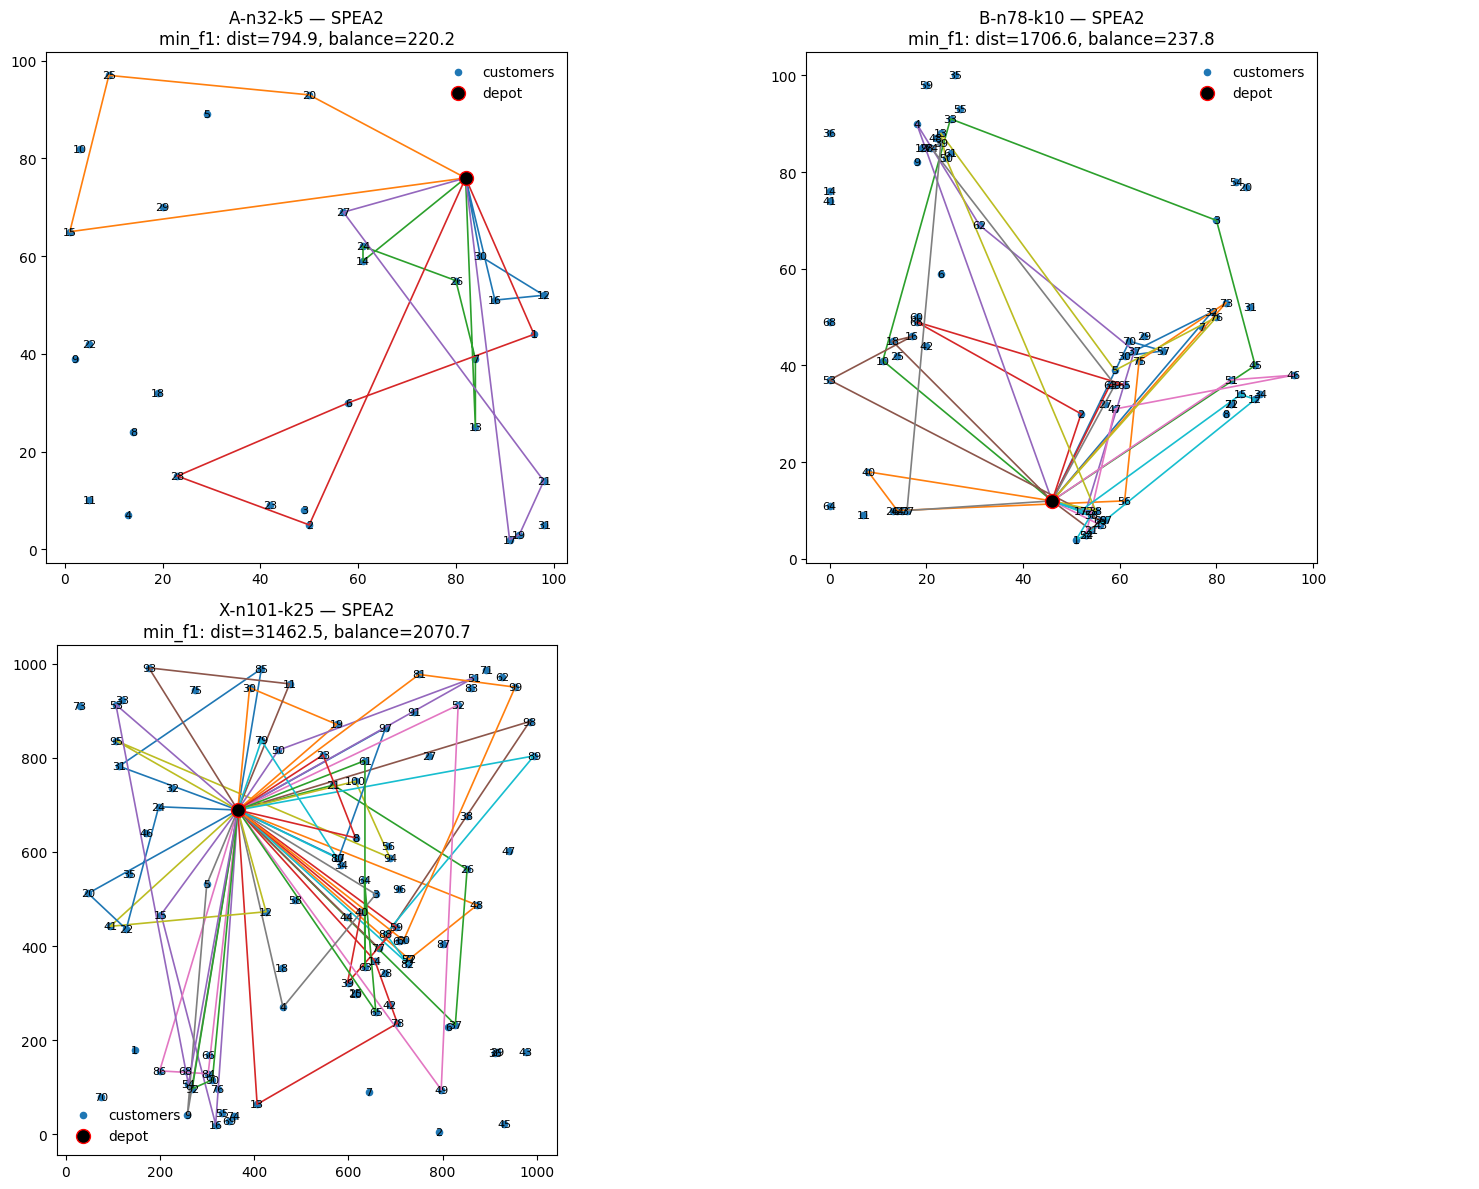

In [18]:
# After instances = try_load_recommended_instances("./cvrp")
# and after defining param_sets (the list of dicts you already have)

# Example 1: plot the 'knee' solution for all instances using NSGA-II and param set #2 (0-based)
visualize_routes_for_all_instances(
    instances,
    alg_name='NSGA-II',
    param_sets=param_sets,
    param_set_index=1,   # choose 0, 1, or 2 from your list
    selection='knee',    # 'knee' | 'min_f1' | 'min_f2'
    number_points=False,
    feasible=True,
    seed=0
)

# Example 2: do the same with SPEA2 and show node labels
visualize_routes_for_all_instances(
    instances,
    alg_name='SPEA2',
    param_sets=param_sets,
    param_set_index=0,
    selection='min_f1',
    number_points=True,
    feasible=True,
    seed=0
)

## Visualization from assignment 1

In [19]:
def plot_routes(ind, customers, depot, n_vehicles, number_points=False, title=None):

    routes = decode_routes(ind, n_vehicles)

    # scatter: customers + depotl
    xs = [xy[0] for xy in customers]
    ys = [xy[1] for xy in customers]
    plt.figure()
    plt.scatter(xs, ys, label="customers")
    plt.scatter([depot[0]], [depot[1]], marker=".", s=400, label="depot", edgecolors= "red", color ="black", zorder=10)

    # draw each route
    for r in routes:
        if not r:
            continue
        # build path: depot (0) -> r -> depot (0)
        xs_path = [depot[0]] + [customers[i-1][0] for i in r] + [depot[0]]
        ys_path = [depot[1]] + [customers[i-1][1] for i in r] + [depot[1]]
        plt.plot(xs_path, ys_path, linewidth=1.0)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.legend()
    plt.title(title or f"Decoded Routes (vehicles={n_vehicles})")
    plt.show()

# Choosing the instance
instance = Instance1_smallgroup

dmat = distance_matrix(instance.depot, instance.customers)

# Running the GA
best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=len(instance.customers), V=instance.vehicles, pop_size=120, generations=20, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2, seed=42, log_convergence=True)


# Ploting the routes
plot_routes(best_ind, customers=instance.customers, depot=instance.depot, n_vehicles=instance.vehicles, number_points=False,
            title=f"GA Best in the Instance 1 of the Small Group  (total distance = {best_dist:.1f})")

NameError: name 'Instance1_smallgroup' is not defined

In [ ]:
# List of instances
instances = [Instance1_smallgroup, Instance2_smallgroup, Instance3_mediumgroup,
             Instance4_mediumgroup, Instance5_largegroup, Instance6_largegroup]

n_instances = len(instances)
cols = 2
rows = (n_instances + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
axes = axes.flatten()

for idx, instance in enumerate(instances):
    dmat = distance_matrix(instance.depot, instance.customers)

    # Running GA
    best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=len(instance.customers), V=instance.vehicles, pop_size=120, generations=20, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2,  seed=42, log_convergence=True)

    # Decode routes
    routes = decode_routes(best_ind, instance.vehicles)

    # Plot on subplot
    ax = axes[idx]
    xs = [xy[0] for xy in instance.customers]
    ys = [xy[1] for xy in instance.customers]
    ax.scatter(xs, ys, label="customers")
    ax.scatter([instance.depot[0]], [instance.depot[1]], marker=".", s=400, label="depot",
               edgecolors="red", color="black", zorder=10)

    for r in routes:
        if not r:
            continue
        xs_path = [instance.depot[0]] + [instance.customers[i-1][0] for i in r] + [instance.depot[0]]
        ys_path = [instance.depot[1]] + [instance.customers[i-1][1] for i in r] + [instance.depot[1]]
        ax.plot(xs_path, ys_path, linewidth=1.0)

    ax.set_aspect("equal", adjustable="box")
    ax.legend()
    ax.set_title(f"Instance {idx+1}: GA Best (dist={best_dist:.1f})")

# Hiding all the empty subplots
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## **5. Performance Evaluation**

- Compare metrics such as total distance, GA runtime and convergence behavior of small, medium and large

- Test 3 sets of GA parameters and run all the 6 instances with all the 3 parameters sets, record metrics and compare the results

In [ ]:
param_sets = {
    "Balanced": {
        "pop_size": 50, "generations": 200, "k_tourn": 3,
        "pc": 0.7, "pm_perm": 0.01, "pm_cuts": 0.1
    },
    "High exploration": {
        "pop_size": 150, "generations": 500, "k_tourn": 3,
        "pc": 0.85, "pm_perm": 0.05, "pm_cuts": 0.2
    },
    "Focus exploitation": {
        "pop_size": 20, "generations": 100, "k_tourn": 3,
        "pc": 0.6, "pm_perm": 0.005, "pm_cuts": 0.5
    }
}

n_runs = 20  # 20 independent seeds

instance_labels = {
    1: "Small-1",
    2: "Small-2",
    3: "Medium-3",
    4: "Medium-4",
    5: "Large-5",
    6: "Large-6"
}

results = []

for inst_id, instance in enumerate(instances, start=1):
    dmat = distance_matrix(instance.depot, instance.customers)

    for set_name, params in param_sets.items():
        dists = []
        times = []
        histories = []

        for run in range(n_runs):
            start = time.time()
            best_ind, best_dist, best_hist = genetic_algorithm(
                dmat,
                N=len(instance.customers),
                V=instance.vehicles,
                seed=run,
                log_convergence=True,
                **params
            )
            runtime = time.time() - start

            dists.append(best_dist)
            times.append(runtime)
            histories.append(best_hist)

        results.append({
            "Instance": inst_id,
            "Group": instance_labels[inst_id],
            "ParamSet": set_name,
            "BestDist": float(np.min(dists)),
            "MeanDist": float(np.mean(dists)),
            "WorstDist": float(np.max(dists)),
            "StdDist": float(np.std(dists)),
            "BestRuntime": float(np.min(times)),
            "MeanRuntime": float(np.mean(times)),
            "WorstRuntime": float(np.max(times)),
            "RuntimeStd": float(np.std(times)),
            "Histories": histories
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Optional: reorder columns nicely
cols = [
    "Instance", "Group", "ParamSet",
    "BestDist", "MeanDist", "WorstDist", "StdDist",
    "BestRuntime", "MeanRuntime", "WorstRuntime", "RuntimeStd",
    "Histories"
]
df_results = df_results[cols]

# Save to CSV
df_results.to_csv("results.csv", index=False)

# Optional preview
# print(df_results.head())


### **5.1 Mean Runtime**

In [ ]:
# Helper function to plot any metric per instance
def plot_instance_metric(series, series_name, series_index=0, ycol="MeanDist"):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Instance']
    ys = series[ycol]

    plt.plot(xs, ys, marker='o', label=series_name,
             color=palette[series_index % len(palette)])

# Plot Mean Runtime for each parameter set
plt.figure(figsize=(8, 4))
df_results_sorted = df_results.sort_values('Instance')

for i, (name, group) in enumerate(df_results_sorted.groupby("ParamSet")):
    plot_instance_metric(group, series_name=name, series_index=i, ycol="MeanRuntime")

plt.title("Mean Runtime per Instance")
plt.xlabel("Instance")
plt.ylabel("Mean Runtime (seconds)")

plt.xticks(
    ticks=df_results_sorted["Instance"].unique(),
    labels=[instance_labels[i] for i in df_results_sorted["Instance"].unique()]
)

plt.legend(title="ParamSet")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()


In [ ]:
#barchart
pivot = df_results.pivot(index="Group", columns="ParamSet", values="MeanRuntime")

# Define the desired order
group_order = ["Small-1", "Small-2", "Medium-3", "Medium-4", "Large-5", "Large-6"]
pivot = pivot.reindex(group_order)

# Plot
ax = pivot.plot(kind="bar", figsize=(10, 4))
ax.set_title("Mean Runtime by Instance Label")
ax.set_xlabel("Instance")
ax.set_ylabel("Seconds")
ax.spines[['top', 'right']].set_visible(False)
plt.legend(title="ParamSet")

# Show values on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=2)

plt.tight_layout()
plt.show()

### **5.2 Mean Distance**

In [ ]:

# Mean Distance plot
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Instance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ParamSet')):
    plot_instance_metric(series, series_name, i, ycol="MeanDist")
fig.legend(title='ParamSet', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Instance')
plt.ylabel('Mean Dist')
plt.xticks(ticks=df_sorted['Instance'].unique(),
           labels=[instance_labels[i] for i in df_sorted['Instance'].unique()])
plt.show()


distance increases with instance size. Differences between parameter sets are small, but larger populations or more generations tend to provide slightly better results on the medium and large instances.

### 5.3 **Best distance**

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Instance', ascending=True)

for i, (series_name, series) in enumerate(df_sorted.groupby('ParamSet')):
    plot_instance_metric(series, series_name, i, ycol="BestDist")

fig.legend(title='ParamSet', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Instance')
plt.ylabel('Best Distance')
plt.xticks(
    ticks=df_sorted['Instance'].unique(),
    labels=[instance_labels[i] for i in df_sorted['Instance'].unique()]
)
plt.show()


### **5.4 convergence curves**

In [ ]:
# Helper: ensure Histories is a list-of-lists (after CSV it may be a string)
def parse_histories(H):
    if isinstance(H, str):
        return ast.literal_eval(H)
    return H
# One figure per (Instance, ParamSet): faint lines = each run; bold = mean curve
dfh = df_results.copy()
dfh["Histories"] = dfh["Histories"].apply(parse_histories)

for (inst, pset), row in dfh.groupby(["Instance","ParamSet"]):
    runs = row.iloc[0]["Histories"]  # list of lists (one per run)
    # Plot each run
    plt.figure(figsize=(7,4))
    for r in runs:
        plt.plot(r, alpha=0.35)
    # Mean curve across runs (same length within a param set)
    maxlen = max(len(r) for r in runs)
    arr = np.vstack([np.array(r + [r[-1]]*(maxlen-len(r))) for r in runs])  # pad just in case
    mean_curve = arr.mean(axis=0)
    plt.plot(mean_curve, linewidth=2.5, label="Mean", zorder=10)
    plt.title(f"Convergence — Instance {inst} ({dfh.loc[dfh['Instance']==inst,'Group'].iloc[0]}), {pset}")
    plt.xlabel("Generation")
    plt.ylabel("Best Distance")
    plt.legend()
    plt.gca().spines[['top','right']].set_visible(False)
    plt.show()


### **6.Summary**
- tables that sumarize the result

In [ ]:
dfh["Histories"] = dfh["Histories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
ps_map = {
    "Balanced": "A",
    "High exploration": "B",
    "Focus exploitation": "C"
}
dfh["ParamCode"] = dfh["ParamSet"].map(ps_map)

### **6.1 Solution quality table**

In [ ]:
q = dfh.copy()
q = q.rename(columns={
    "BestDist": "Best",
    "MeanDist": "Avg",
    "WorstDist": "Worst"
})

tbl_quality = (
    q.pivot(index="Instance", columns="ParamCode", values=["Best", "Avg", "Worst"])
     .swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
     .reindex(columns=["A", "B", "C"], level=0)
     .round(3).astype(int)  # whole numbers
)

#tbl_quality.to_csv("table_solution_quality.csv")
display(tbl_quality.style.set_caption("Solution Quality"))


### **6.2 Computational efficiency table**

In [ ]:
e = dfh.rename(columns={
    "BestRuntime": "Best",
    "MeanRuntime": "Avg",
    "WorstRuntime": "Worst"
})[["Instance", "ParamCode", "Best", "Avg", "Worst"]]

tbl_eff = (
    e.pivot(index="Instance", columns="ParamCode", values=["Best", "Avg", "Worst"])
     .swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
     .reindex(columns=["A", "B", "C"], level=0)
     .round(4)
)

#tbl_eff.to_csv("table_computational_efficiency.csv")
display(tbl_eff.style.set_caption("Computational Efficiency"))


### **6.3 Convergence table**

In [ ]:
EPS = 0.05

def gens_to_within_eps(hist, eps=EPS):
    final = hist[-1]
    thresh = final * (1 + eps)
    for g, v in enumerate(hist):
        if v <= thresh:
            return g
    return len(hist) - 1

rows = []
for _, r in dfh.iterrows():
    gens = [gens_to_within_eps(h) for h in r["Histories"]]
    rows.append({
        "Instance": r["Instance"],
        "ParamCode": r["ParamCode"],
        "Best": min(gens),
        "Avg": round(sum(gens)/len(gens), 0),
        "Worst": max(gens)
    })

c = pd.DataFrame(rows)

tbl_convergence = (
    c.pivot(index="Instance", columns="ParamCode", values=["Best", "Avg", "Worst"])
     .swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
     .reindex(columns=["A", "B", "C"], level=0)
     .round(0).astype(int)
)

#tbl_convergence.to_csv("table_convergence_rate.csv")
display(tbl_convergence.style.set_caption("Convergence Rate"))
